In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import env
import wrangle
import os

# turn off warning boxes for demo
import warnings
warnings.filterwarnings("ignore")


# change display settings to show all columns
pd.set_option("display.max_columns", None)

# Project Goals and Ideas
Matthew Luna, April 8, 2022

# Executive Summary
## What is driving the errors in the Zillow Zestimates?

- For this project the target is logerror
    
## Project Description
- Build a model that helps reduce the logerror for Zillow Zestimates for single family properties in 2017
- All models are compared and evaluated on its performance over the baseline

## Acquisition and Preparation

In [2]:
df = wrangle.get_zillow_data()
df.shape

Using cached csv


(77580, 69)

## Prepare process:
- After acquiring data from the mySQL server through wrangle.py
    - Become familiar with the data by:
        - using functions like .shape, .dtypes, .isna(), and .value_counts()
- Create functions in my .py file that do the following:
    - Remove columns based on % of missing values
    - Remove nulls and outliers
    - Change data types where necessary
    - Feature engineer columns like age, county, dollars_per_sqft, taxrate
    - Make dummy variables for county columns and clusters created
    - Visualize data and observe distributions
    - Clean data, split data, and scale the data

In [3]:
# Clean data and prep for splitting

df = wrangle.clean_zillow(df)

In [4]:
# Split original df into train, validate, test

train, validate, test = wrangle.split_data(df)

In [5]:
# Run handle_nulls function on splits to prepare data for exploration

train, validate, test = wrangle.handle_nulls(train, validate, test)
train.shape, validate.shape, test.shape

((34204, 26), (14659, 26), (12216, 26))

# Data Context

- The original dataset was made up of 77,580 rows and 69 columns

- After the preparation process:
    - Cleaned data is made up of 61,079 rows and 25 columns
    - Null values and outliers have been removed
    - Data types values are appropriate columns
    - Data is ready for exploration
     
    
- 78% of the original dataset remains to be explored

# Exploration

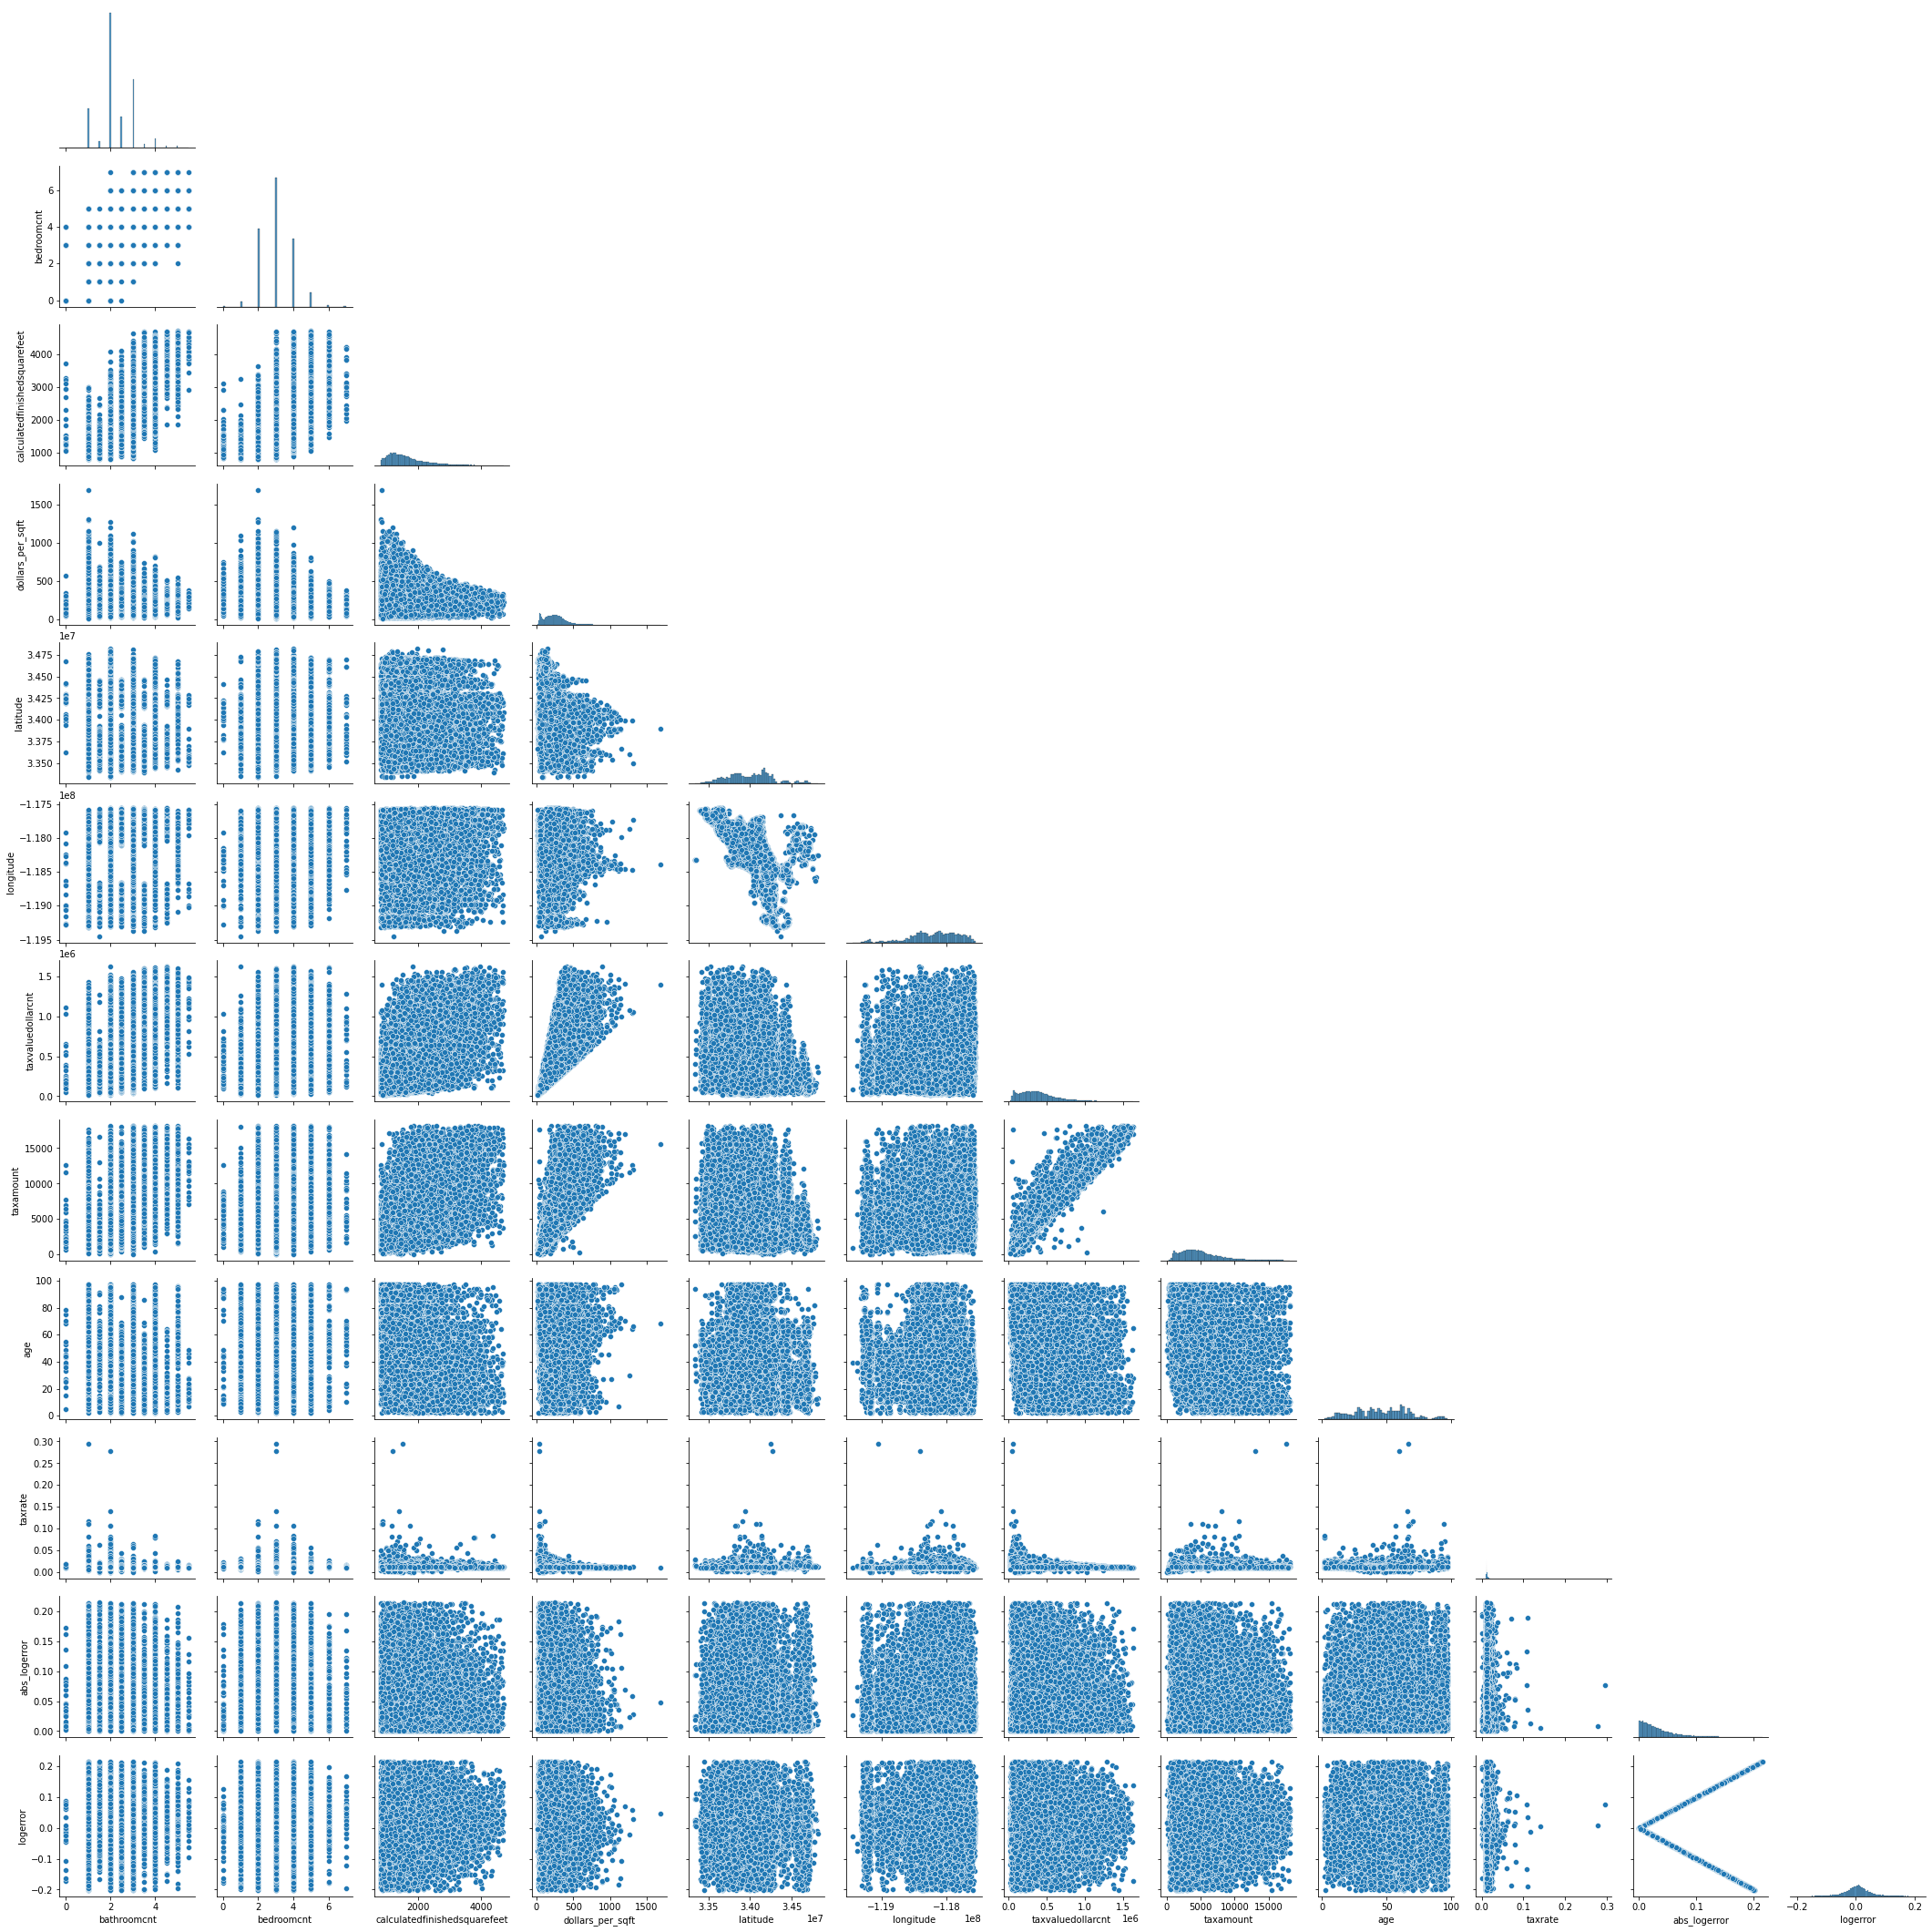

In [6]:
wrangle.show_pairplot(train)

## Takeaway
     - calculatedfinishedsquarefeet has more volume for homes under about 3000 sqft
     - latitude and longitude look like there could 
     - homes in the area range all the way to 100 years

In [7]:
# Set up variables for exploration
target = 'logerror'


variables = ['calculatedfinishedsquarefeet',
            'dollars_per_sqft',
            'latitude',
            'longitude',
            'structuretaxvaluedollarcnt',
            'taxvaluedollarcnt',
            'landtaxvaluedollarcnt',
            'taxamount',
            'age',
            'taxrate']

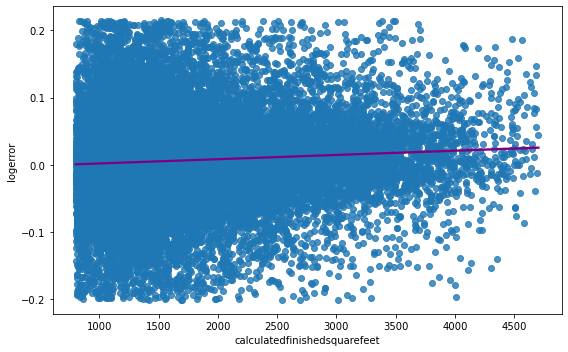

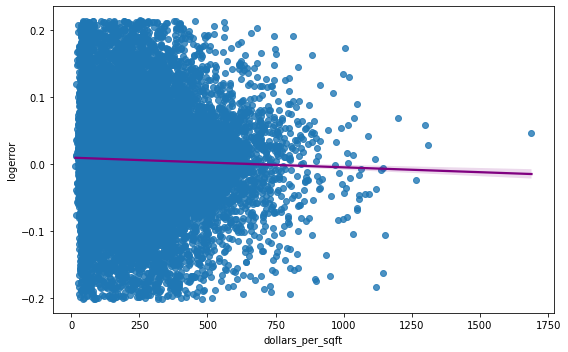

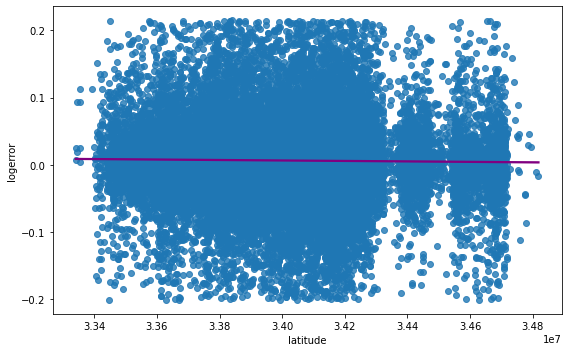

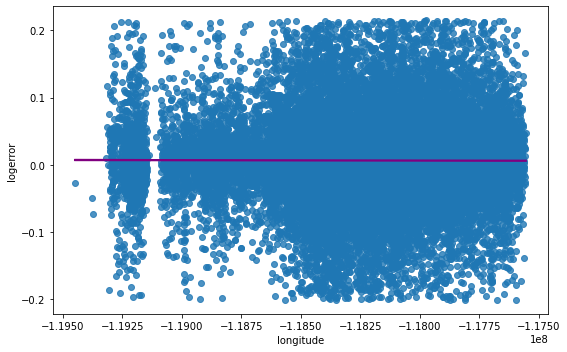

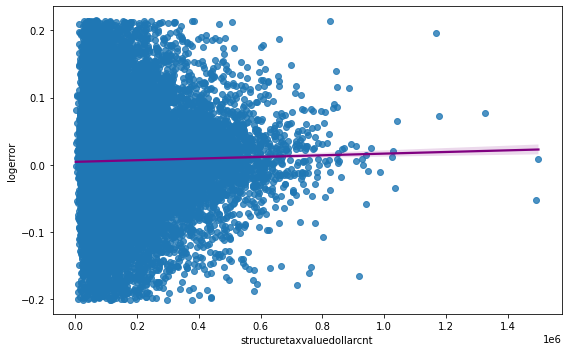

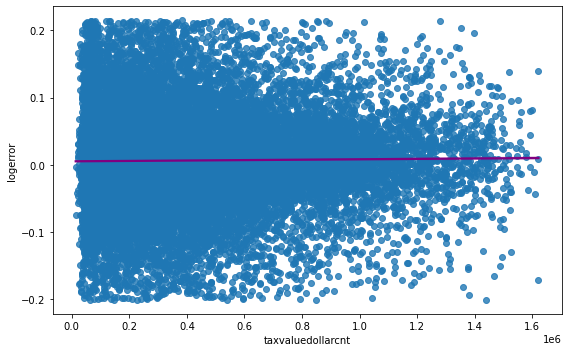

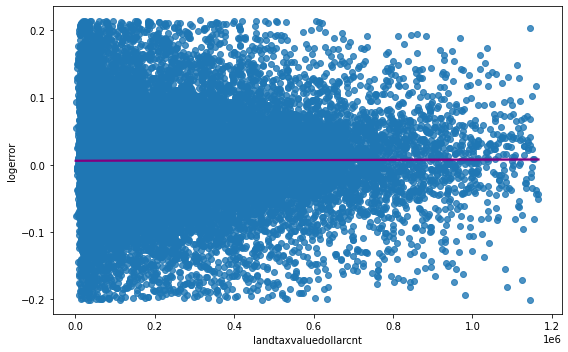

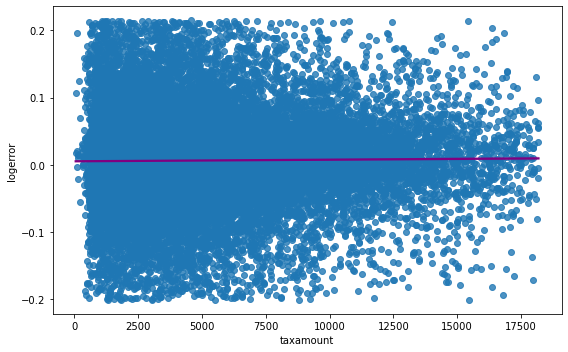

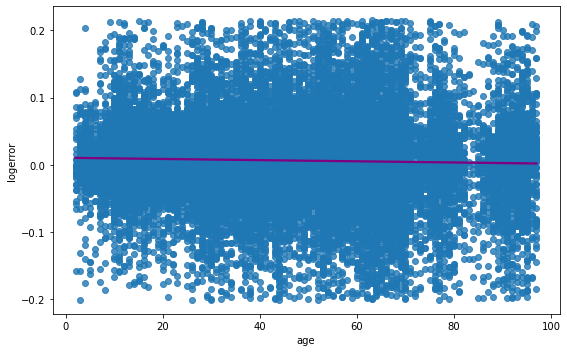

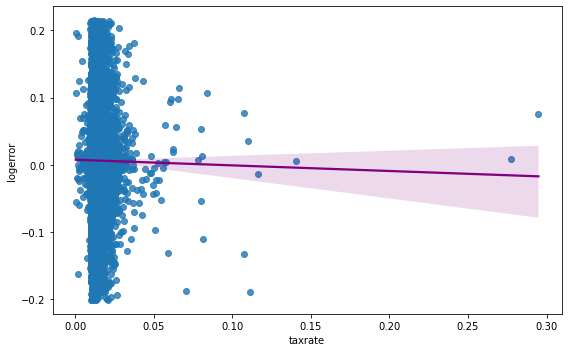

In [8]:
wrangle.target_regplot(train, target, variables)

# Takeaway
- Latitude and Longitude have changes in logerror
- As square footage increase logerror reduces
- Other information is difficult to come to from this

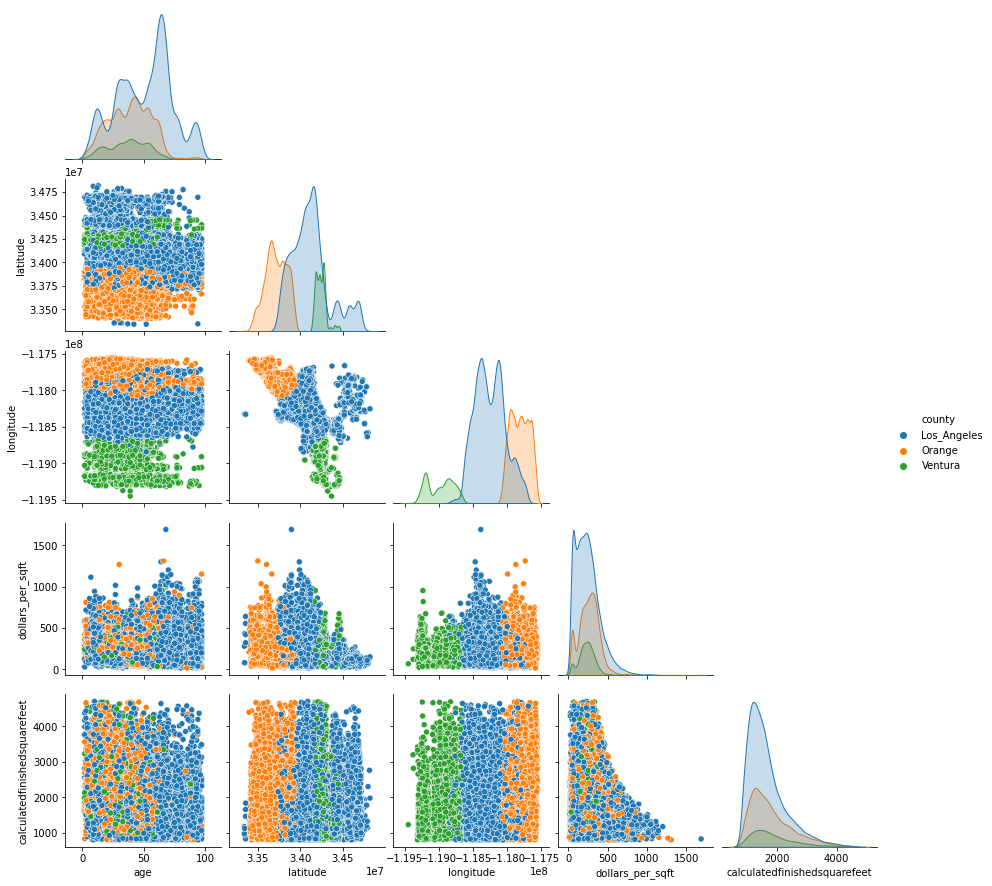

In [9]:
wrangle.county_plots(train)

# Questions

- dollars_per_sqft affect logerror?
- county and logerror?
- age and logerror?
- does latitude/longitude affect logerror?

# Question 1 
    - How does county affect logerror?

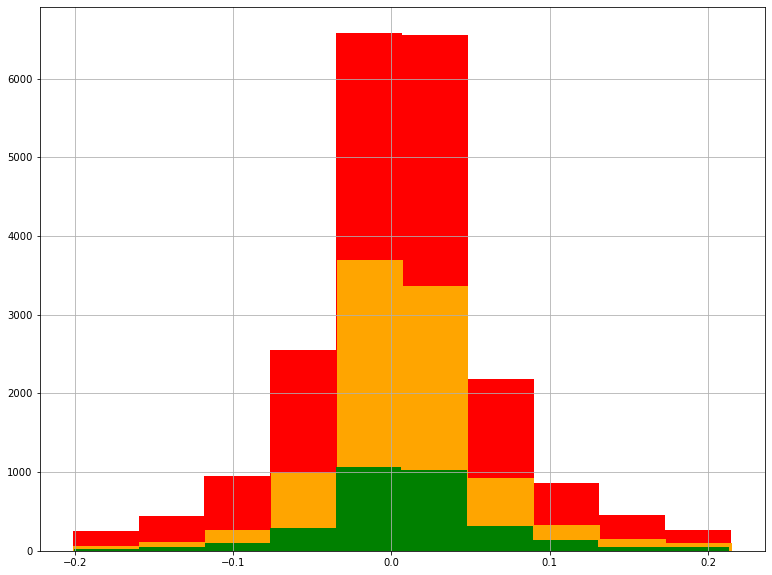

In [10]:

plt.figure(figsize= (13,10))
ax = train[train.county == 'Los_Angeles'].logerror.hist(color = 'red')
train[train.county == 'Orange'].logerror.hist(ax = ax, color = 'orange')
train[train.county == 'Ventura'].logerror.hist(ax = ax, color = 'green')
plt.show()

#### Takeaways
- Most houses in order by county are LA, Orange, Ventura
- logerror may differ from county to county because of the volume of houses

### Hypothesis/Stats
- Null: Median logerror of LA county == median logerror
- Alternative: Median logerror of LA county != median logerror

In [11]:
alpha = .05

t, p = stats.ttest_1samp(train[train.county == 'Orange'].logerror, train['logerror'].median() )
t, p 

(3.314153059394819, 0.0009224840416609692)

- P is less than our alpha, we can reject the null hypothesis and see that logerror will vary from county to county
- WIth a positive t value we can assume that median logerror may be higher with this group

# Question 2
### - Does age affect logerror?

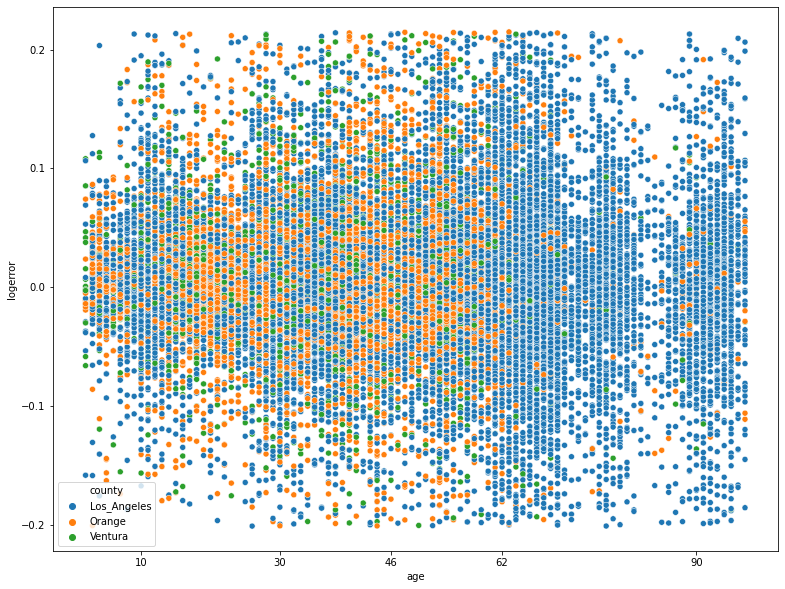

In [12]:
plt.figure(figsize = (13,10))
sns.scatterplot(train.age, train.logerror, hue =train.county)
plt.xticks(ticks =(10, 30, 46, 62, 90))
plt.show()

#### Takeaway
- not too much to takeaway from logerror and mean prediction
- is interesting to see where the counties fall as far as age range

### Hypothesis/Stats
Null: There is no linear correlation between age and logerror

Alternative: There is a linear correlation between age and logerror

In [13]:
alpha = 0.05

#test = pearsonr 

r, p = stats.pearsonr(train['age'], train['logerror'])
print(f't = {r}, p = {p}')

t = -0.032118838791157664, p = 2.8246425755225112e-09


- p is less than our alpha, we can reject the null hypothesis
- There is evidence to support a linear correlation between age and logerror

# Question 3
### - How does square foot of house affect logerror?

<Figure size 1080x720 with 0 Axes>

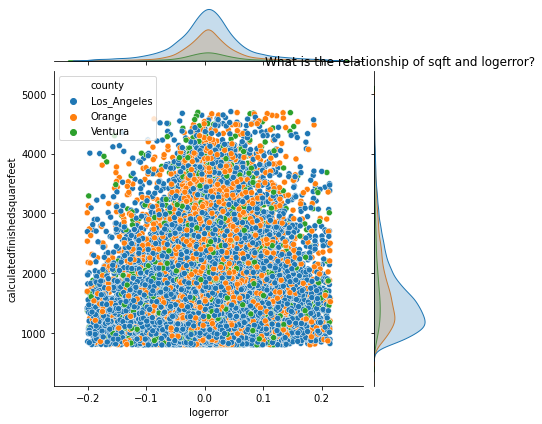

In [14]:
# visualize logerror and lotsize while controlling for newer age
plt.figure(figsize = (15,10))
sns.jointplot(x='logerror', y='calculatedfinishedsquarefeet', 
                data=train, hue = 'county')
plt.title("What is the relationship of sqft and logerror?")
plt.show()

### Hypothesis/Stats
H0: There is no linear correlation between home sqft and logerror

Ha:There is a linear correlation between home sqft and logerror

In [15]:
alpha = 0.05

#test = Pearson r

r, p = stats.pearsonr(train['calculatedfinishedsquarefeet'], train['logerror'])
print(f't = {r}, p = {p}')

t = 0.07536355463662836, p = 2.8390495242002787e-44


- p is less than alpha, we can reject the null hypothesis
- we can assume there is a linear correlation with sqft and logerror

# Statistical analysis summary

- Supports a linear relationship between square_ft, bathrooms, bedrooms, lot size and the property tax value

# Questions 4
### - Does latitude and longitude affect logerror?

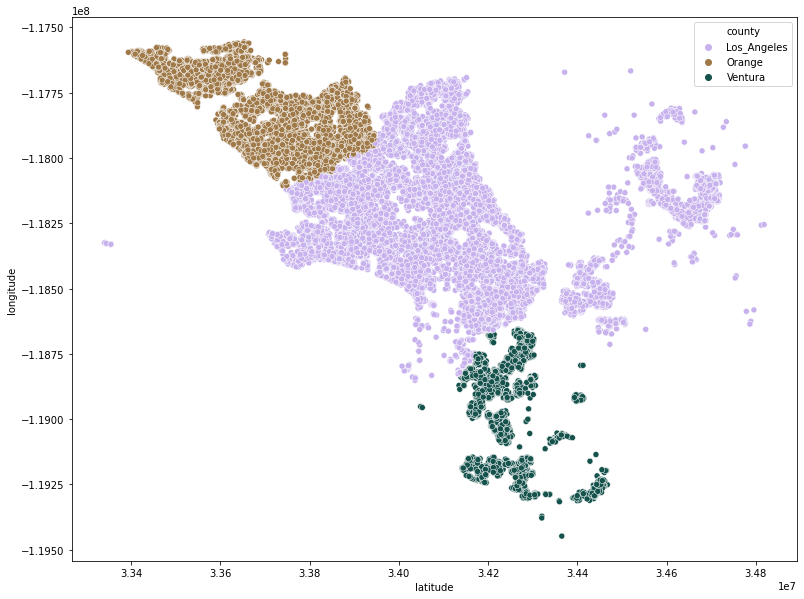

In [16]:
plt.figure(figsize = (13,10))
sns.scatterplot(x='latitude', y ='longitude', data = train, hue = 'county', palette = 'cubehelix_r')
plt.show()

# Takeaways

- There are linear relationships between bedroom, bathroom, lot_size, square_ft, and tax_value assessment
- Square_ft has the strongest correlation out of the features
- The listed features will be used to fit the model and evaluate performance

# Clustering

## Cluster 1  
### - columns included are age, latitude, and longitude

In [17]:
#set variables to scaled for clustering
X_train = train[['age', 'latitude', 'longitude']]


X_train_scaled, minmax_scaler = wrangle.scale_this(X_train, MinMaxScaler())

In [18]:
X_train_scaled.head()

age  latitude  longitude
34423  0.557895  0.521163   0.900139
31856  0.136842  0.178461   0.833424
59878  0.284211  0.583281   0.245729
26590  0.568421  0.536971   0.521556
6289   0.442105  0.456098   0.511444

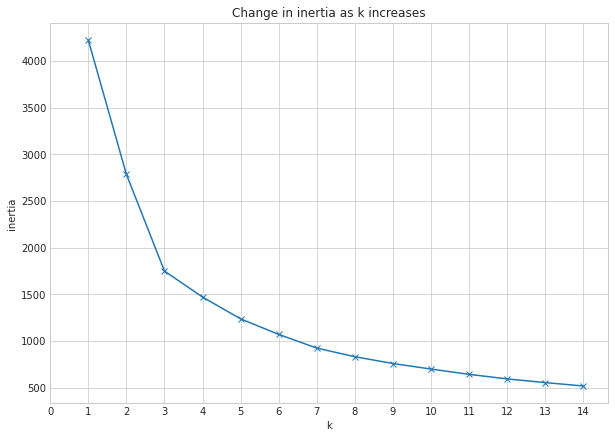

In [19]:
# Use elbow method to choose a k value

wrangle.plot_inertia(X_train_scaled, k_range_end = 15)

In [20]:
X_train_scaled, centroids_scaled, kmeans = wrangle.cluster_creator(X_train, 5,  col_name = 'lat_long_age_cluster')

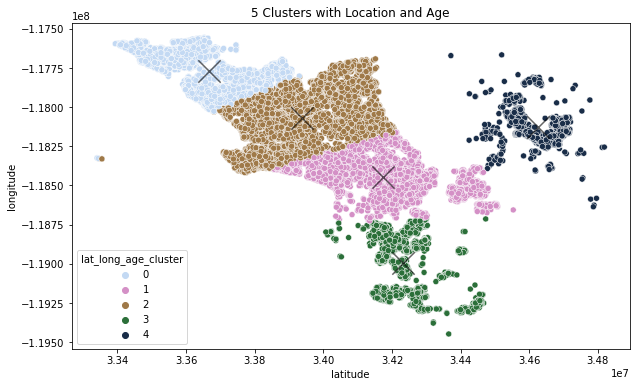

In [21]:
wrangle.scatterplot_clusters('latitude', 'longitude', 'lat_long_age_cluster', X_train_scaled, kmeans, minmax_scaler, centroids_scaled)
plt.title('5 Clusters with Location and Age')
plt.show()

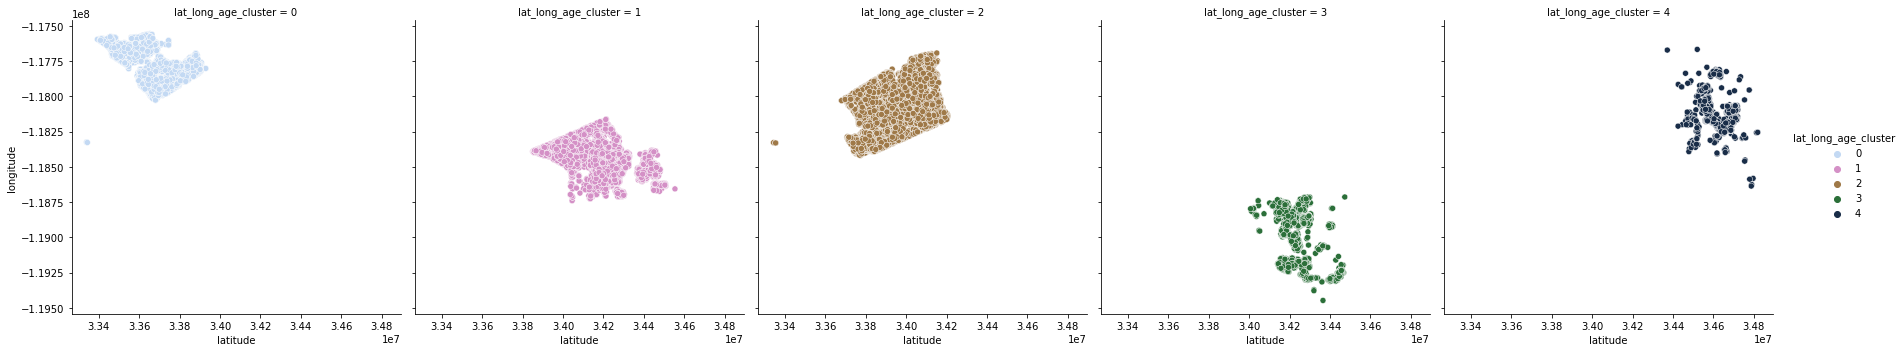

In [22]:
# One column per latitude
# One color/shape for each cluster label
sns.relplot('latitude', 'longitude', 'lat_long_age_cluster', col = 'lat_long_age_cluster', data=X_train_scaled, palette = 'cubehelix_r')
plt.show()

In [23]:
train['lat_long_age_cluster'] = X_train_scaled['lat_long_age_cluster']
validate['lat_long_age_cluster'] = X_train_scaled['lat_long_age_cluster']
test['lat_long_age_cluster'] = X_train_scaled['lat_long_age_cluster']

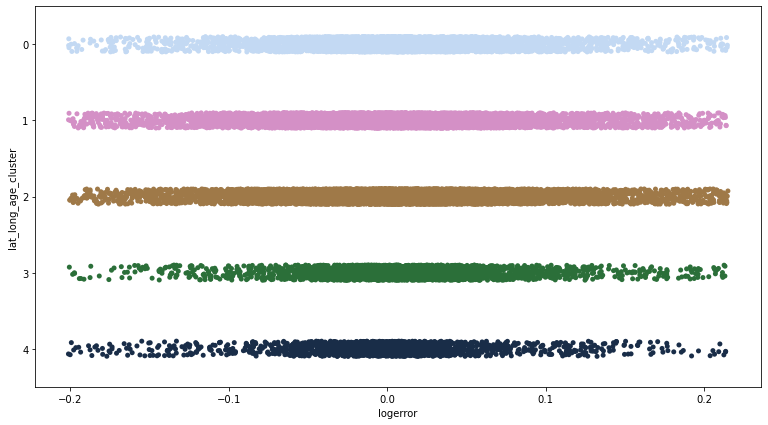

In [24]:
x = train.logerror
y = train.lat_long_age_cluster
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(10000), palette = 'cubehelix_r')

## Cluster 2 
###    - Columns included are age, dollars_per_sqft, calculatedfinishedsquarefeet

In [25]:
# set up columns for cluster
X_train2 = train[['calculatedfinishedsquarefeet', 'age' , 'dollars_per_sqft']]
# scale columns
X_train_scaled, minmax_scaler = wrangle.scale_this(X_train2, MinMaxScaler())

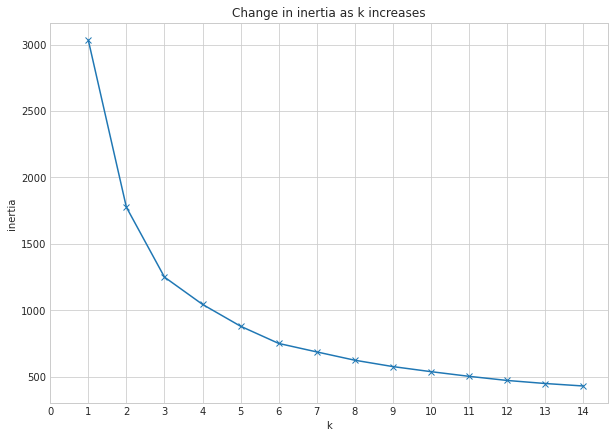

In [26]:
wrangle.plot_inertia(X_train_scaled, k_range_end = 15)

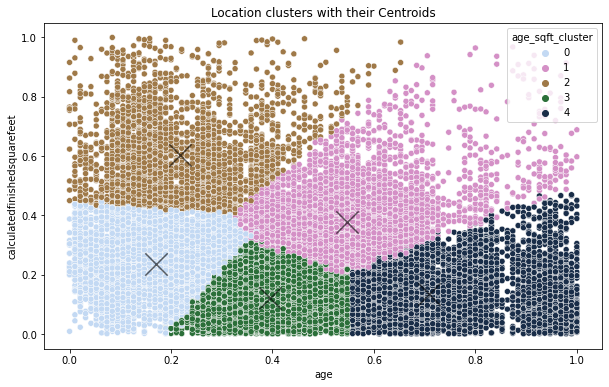

In [27]:
# create cluster with n = 11
X_train_scaled, centroids_scaled, kmeans = wrangle.cluster_creator(X_train_scaled, 5, 'age_sqft_cluster')
wrangle.scatterplot_clusters('age', 'calculatedfinishedsquarefeet', 'age_sqft_cluster', X_train_scaled, kmeans, minmax_scaler, centroids_scaled)

plt.title("Location clusters with their Centroids")
plt.show()

In [28]:
# Add clusters to dataframe for plotting
train['age_sqft_cluster'] = X_train_scaled['age_sqft_cluster']
validate['age_sqft_cluster'] = X_train_scaled['age_sqft_cluster']
test['age_sqft_cluster'] = X_train_scaled['age_sqft_cluster']

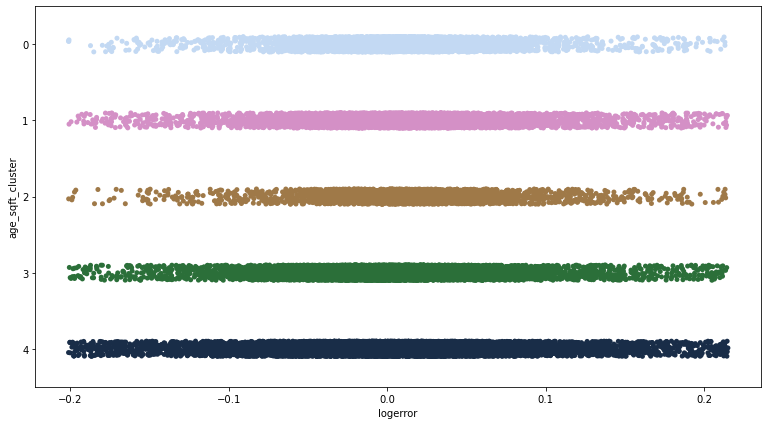

In [29]:
#create a striplot for clusters and logerror
x = train.logerror
y = train.age_sqft_cluster
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(10000), palette = 'cubehelix_r')

### Takeaways
- There isn't much that stands out between the clusters and logerror
- further evaluation into features and best k values is needed to find more impactful clusters

In [30]:
# This function will reset my train, validate, and test data with encoded columns and proper scaling for the modeling phase

train, validate, test, scaler = wrangle.some_magic()

Using cached csv


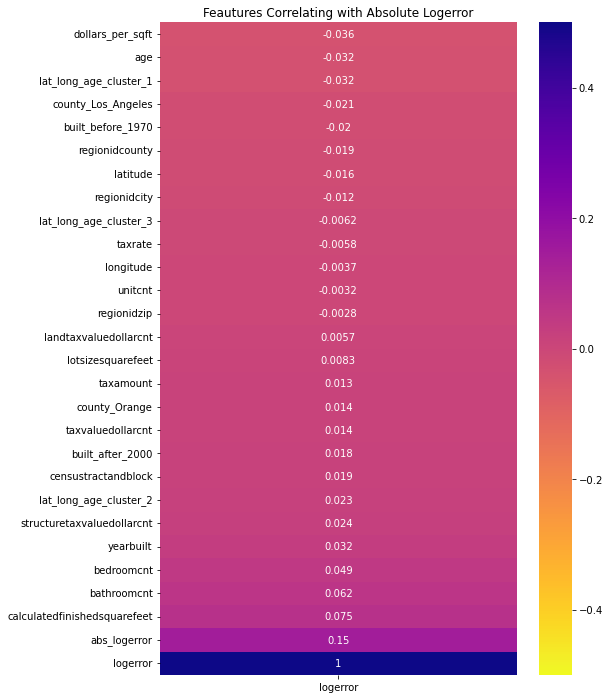

In [31]:
# create heatmap with scaled data and encoded clustered columns

plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train.corr()[['logerror']].sort_values(by='logerror', ascending=True), 
                            cmap='plasma_r', vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Absolute Logerror')
plt.show()

# Cluster stats testing

- H0: Median logerror of lat_long_age_cluster_1 == median logerror
- HA: Median logerror of lat_long_age_cluster_1 != median logerror

In [32]:
alpha = .05

t, p = stats.ttest_1samp(train[train.lat_long_age_cluster_2 == 1].logerror, train['logerror'].median())
t, p 

(5.0494755624959735, 4.5038225922947147e-07)

- P value less than alpha means we can reject the null hypothesis
- Positive t might be evidence that median error is higher with this group.

## Median Baseline

In [33]:
train.logerror.median()

0.00585512021372

In [58]:
train, validate, test = wrangle.get_median_baseline(train, validate, test)
train.baseline.median(), validate.baseline.median()

(0.00585512021372, 0.00447096669281)

In [35]:
X_cols = list(train.drop(columns = ['abs_logerror', 'logerror', 'baseline', 'transactiondate', 'heatingorsystemdesc', 'propertylandusedesc']))
y_col = 'logerror'

X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.get_X_train_y_train(X_cols, y_col, train, validate, test)

In [36]:
X_train.head()

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
34423     0.363636    0.428571                      0.260636  0.521163   
31856     0.363636    0.285714                      0.172988  0.178461   
59878     0.454545    0.285714                      0.149667  0.583281   
26590     0.545455    0.714286                      0.508457  0.536971   
6289      0.363636    0.285714                      0.048180  0.456098   

       longitude  lotsizesquarefeet  regionidcity  regionidcounty  \
34423   0.900139            10053.0       20008.0          3101.0   
31856   0.833424             7238.0       53571.0          1286.0   
59878   0.245729             7238.0       51239.0          2061.0   
26590   0.521556            13582.0       12447.0          3101.0   
6289    0.511444             7507.0       26964.0          3101.0   

       regionidzip  unitcnt  yearbuilt  structuretaxvaluedollarcnt  \
34423      96469.0      1.0     1962.0                    0.123996   
31856      96957.0      1.0     2002.0                    0.140792   
59878      97091.0      1.0     1988.0                    0.091113   
26590      96412.0      1.0     1961.0                    0.164840   
6289       96151.0      1.0     1973.0                    0.061668   

       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  \
34423           0.283078               0.240547   0.311447   
31856           0.511731               0.534737   0.499906   
59878           0.123557               0.062516   0.125249   
26590           0.336192               0.261388   0.379897   
6289            0.168592               0.162569   0.199192   

       censustractandblock       age   taxrate  dollars_per_sqft  \
34423         6.037402e+13  0.557895  0.040453          0.144935   
31856         6.059063e+13  0.136842  0.036189          0.329555   
59878         6.111006e+13  0.284211  0.036317          0.082404   
26590         6.037142e+13  0.568421  0.041697          0.109755   
6289          6.037702e+13  0.442105  0.042860          0.162848   

       built_before_1970  built_after_2000  county_Los_Angeles  county_Orange  \
34423                  1                 0                   1              0   
31856                  0                 1                   0              1   
59878                  0                 0                   0              0   
26590                  1                 0                   1              0   
6289                   0                 0                   1              0   

       lat_long_age_cluster_1  lat_long_age_cluster_2  lat_long_age_cluster_3  
34423                       1                       0                       0  
31856                       0                       1                       0  
59878                       0                       0                       0  
26590                       1                       0                       0  
6289                        0                       0                       0

# Modeling
    - LinearRegression 
    - LassoLars
    - TweedieRegressor
    - LassoLars while controlling for county
    
## LinerarRegression OLM

In [37]:
model= LinearRegression()
model_name = 'olm_1'

# fit model
model.fit(train[X_cols], train[y_col])
    
# put predictions in train dataframe
train[model_name] = model.predict(train[X_cols])
#put predictions in validate dataframe
validate[model_name] = model.predict(validate[X_cols])
    
# print confirmation 
print(f'{model_name} has been created and added to train and validate dataframes\n')

olm_1 has been created and added to train and validate dataframes



In [38]:
# calculate model RMSE
model_name = 'olm_1'
rmse = mean_squared_error(train[model_name], y_train, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(train['baseline'], y_train, squared = False)
    
# print it all out
print(f'''------- {'train'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- train ---------

RMSE for olm_1: 0.057621701952361375

RMSE for baseline: 0.057922377082427964

Better than baseline?: True by 0.0003006751300665897
        


In [39]:
# calculate model RMSE
model_name = 'olm_1'
rmse = mean_squared_error(validate[model_name], y_validate, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(validate['baseline'], y_validate, squared = False)
    
# print it all out
print(f'''------- {'validate'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- validate ---------

RMSE for olm_1: 0.05701610815880246

RMSE for baseline: 0.05715602221327595

Better than baseline?: True by 0.0001399140544734931
        


## LassoLars

In [40]:
model= LassoLars(alpha =1.0)
model_name = 'lars_1'

# fit model
model.fit(train[X_cols], train[y_col])
    
# put predictions in train dataframe
train[model_name] = model.predict(train[X_cols])
#put predictions in validate dataframe
validate[model_name] = model.predict(validate[X_cols])
    
# print confirmation 
print(f'{model_name} has been created and added to train and validate dataframes\n')

lars_1 has been created and added to train and validate dataframes



In [41]:
# calculate model RMSE
model_name = 'lars_1'
rmse = mean_squared_error(train[model_name], y_train, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(train['baseline'], y_train, squared = False)
    
# print it all out
print(f'''------- {'train'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- train ---------

RMSE for lars_1: 0.057920421992814636

RMSE for baseline: 0.057922377082427964

Better than baseline?: True by 1.9550896133285756e-06
        


In [42]:
# calculate model RMSE
model_name = 'lars_1'
rmse = mean_squared_error(validate[model_name], y_validate, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(validate['baseline'], y_validate, squared = False)
    
# print it all out
print(f'''------- {'validate'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- validate ---------

RMSE for lars_1: 0.05714765076031355

RMSE for baseline: 0.05715602221327595

Better than baseline?: True by 8.37145296240377e-06
        


## TweedieRegressor

In [43]:
model= TweedieRegressor(power =0.0, alpha = 0.0)
model_name = 'glm_1'

# fit model
model.fit(train[X_cols], train[y_col])
    
# put predictions in train dataframe
train[model_name] = model.predict(train[X_cols])
#put predictions in validate dataframe
validate[model_name] = model.predict(validate[X_cols])
    
# print confirmation 
print(f'{model_name} has been created and added to train and validate dataframes\n')

glm_1 has been created and added to train and validate dataframes



In [44]:
# calculate model RMSE
model_name = 'glm_1'
rmse = mean_squared_error(train[model_name], y_train, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(train['baseline'], y_train, squared = False)
    
# print it all out
print(f'''------- {'train'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- train ---------

RMSE for glm_1: 0.057920421992814636

RMSE for baseline: 0.057922377082427964

Better than baseline?: True by 1.9550896133285756e-06
        


In [45]:
# calculate model RMSE
model_name = 'glm_1'
rmse = mean_squared_error(validate[model_name], y_validate, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(validate['baseline'], y_validate, squared = False)
    
# print it all out
print(f'''------- {'validate'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- validate ---------

RMSE for glm_1: 0.05714765076031355

RMSE for baseline: 0.05715602221327595

Better than baseline?: True by 8.37145296240377e-06
        


## Controlling for LA county and other

In [46]:
train_LA, train_not_LA = wrangle.location_location(train)

validate_LA, validate_not_LA = wrangle.location_location(validate)

test_LA, test_not_LA = wrangle.location_location(test)

In [47]:
X_train_LA, y_train_LA, X_validate_LA, y_validate_LA, X_test_LA, y_test_LA = wrangle.get_X_train_y_train(X_cols, y_col, train_LA, validate_LA, test_LA)

X_train_not_LA, y_train_not_LA, X_validate_not_LA, y_validate_not_LA, X_test_not_LA, y_test_not_LA = wrangle.get_X_train_y_train(X_cols, y_col, train_not_LA, validate_not_LA, test_not_LA)

## LA COUNTY

In [48]:
model= LinearRegression()
model_name = 'olm_2'

# fit model
model.fit(train_LA[X_cols], train_LA[y_col])
    
# put predictions in train dataframe
train_LA[model_name] = model.predict(train_LA[X_cols])
#put predictions in validate dataframe
validate_LA[model_name] = model.predict(validate_LA[X_cols])
    
# print confirmation 
print(f'{model_name} has been created and added to train_LA and validate_LA dataframes\n')

olm_2 has been created and added to train_LA and validate_LA dataframes



In [49]:
# calculate model RMSE
model_name = 'olm_2'
rmse = mean_squared_error(train_LA[model_name], y_train_LA, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(train_LA['baseline'], y_train_LA, squared = False)
    
# print it all out
print(f'''------- {'train_LA'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- train_LA ---------

RMSE for olm_2: 0.060462330501127544

RMSE for baseline: 0.060837152989417984

Better than baseline?: True by 0.0003748224882904397
        


In [50]:
# calculate model RMSE
model_name = 'olm_2'
rmse = mean_squared_error(validate_LA[model_name], y_validate_LA, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(validate_LA['baseline'], y_validate_LA, squared = False)
    
# print it all out
print(f'''------- {'validate_LA'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- validate_LA ---------

RMSE for olm_2: 0.06050947486846397

RMSE for baseline: 0.06061050841492049

Better than baseline?: True by 0.0001010335464565193
        


## NOT LA COUNTY

In [51]:
model= LinearRegression()
model_name = 'olm_3'

# fit model
model.fit(train_not_LA[X_cols], train_not_LA[y_col])
    
# put predictions in train dataframe
train_not_LA[model_name] = model.predict(train_not_LA[X_cols])
#put predictions in validate dataframe
validate_not_LA[model_name] = model.predict(validate_not_LA[X_cols])
    
# print confirmation 
print(f'{model_name} has been created and added to train_LA and validate_LA dataframes\n')

olm_3 has been created and added to train_LA and validate_LA dataframes



In [52]:
# calculate model RMSE
model_name = 'olm_3'
rmse = mean_squared_error(train_not_LA[model_name], y_train_not_LA, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(train_not_LA['baseline'], y_train_not_LA, squared = False)
    
# print it all out
print(f'''------- {'train_not_LA'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- train_not_LA ---------

RMSE for olm_3: 0.05261931162071575

RMSE for baseline: 0.05289123534587535

Better than baseline?: True by 0.00027192372515959934
        


In [53]:
# calculate model RMSE
model_name = 'olm_3'
rmse = mean_squared_error(validate_not_LA[model_name], y_validate_not_LA, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(validate_not_LA['baseline'], y_validate_not_LA, squared = False)
    
# print it all out
print(f'''------- {'validate_not_LA'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- validate_not_LA ---------

RMSE for olm_3: 0.05092814270504217

RMSE for baseline: 0.05116397823980776

Better than baseline?: True by 0.00023583553476558966
        


### Controlling for county takeaways
- controlling for Los Angeles county proved to be better for minimizing logerror 
- LA county has a higher logerror than the other counties

- While outside counties had a lower median logerror the modes did still perform better

## Takeaways

- All models performed better than the baseline
- The improvement was better but not by much, my top two performers were
    - LinearRegression olm_1: 
    Better than baseline by: 0.012183191073234595
    - LinearRegression olm_3:
    Better than baseline by: 0.015544305995229879



In [55]:
#fit model
model = LinearRegression()
model_name = 'olm_1'
model.fit(train[X_cols], train[y_col])
    
#put predictions in train dataframe
train[model_name] = model.predict(train[X_cols])
    
#put predictions in validate dataframe
validate[model_name] = model.predict(validate[X_cols])
    
test[model_name] = model.predict(test[X_cols])
    
#print confirmation instead of returning something
print(f'{model_name} has been created and added to train and validate dataframes\n')
    
# compare the RMSEs (this function prints out RMSE comparisons 

rmse = mean_squared_error( train[model_name], train[y_col])
print(f'train rmse is: {rmse}')
rmse = mean_squared_error( validate[model_name], validate[y_col])
print(f'validate rmse is: {rmse}')

olm_1 has been created and added to train and validate dataframes

train rmse is: 0.003320260535886767
validate rmse is: 0.00325083658957626


In [56]:
# calculate model RMSE
model_name = 'olm_1'
rmse = mean_squared_error(test[model_name], y_test, squared = False)
    
# calculate baseline RMSE 
rmse_b = mean_squared_error(test['baseline'], y_test, squared = False)
    
# print it all out
print(f'''------- {'test'} ---------\n
RMSE for {model_name}: {rmse}\n
RMSE for baseline: {rmse_b}\n
Better than baseline?: {rmse < rmse_b} by {rmse_b - rmse}
        ''')

------- test ---------

RMSE for olm_1: 0.058227094704113726

RMSE for baseline: 0.05840486150683438

Better than baseline?: True by 0.00017776680272065665
        


# Conclussion
- All models performed better than the baseline 
    - even if not by much
- cluster with latitude, longitude, and age brought some value for minimizing logerror
- Given more time
    - I would like to look deeper into other clusters with better features